In [4]:
pip install umap-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00


In [169]:
import pandas as pd
import umap as um
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
warnings.filterwarnings('ignore')
# Loading the time series data with date parsing
data = pd.read_csv("/2015_Air_quality_in_northern_Taiwan.csv", parse_dates=['time'])



In [170]:
# Deleting the rows with NA in 'PM2.5', because we need to predict PM2.5
data = data[data['PM2.5'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215768 entries, 0 to 218639
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        215768 non-null  datetime64[ns]
 1   station     215768 non-null  object        
 2   AMB_TEMP    198538 non-null  object        
 3   CH4         95104 non-null   object        
 4   CO          215577 non-null  object        
 5   NMHC        94927 non-null   object        
 6   NO          215509 non-null  object        
 7   NO2         215102 non-null  object        
 8   NOx         215510 non-null  object        
 9   O3          198280 non-null  object        
 10  PH_RAIN     34202 non-null   object        
 11  PM10        215561 non-null  object        
 12  PM2.5       215768 non-null  object        
 13  RAINFALL    207268 non-null  object        
 14  RAIN_COND   34202 non-null   object        
 15  RH          198612 non-null  object        
 16  SO2    

In [171]:
# List of columns to drop
columns_to_drop = ['UVB', 'RAIN_COND', 'PH_RAIN']

# Check and drop columns if they exist
data.drop([col for col in columns_to_drop if col in data.columns], axis=1, inplace=True)

In [172]:
def numeric(row):
    try:
        if np.isnan(row):
            return
        else:
            row =str(row)
            return float(row.replace('x','').replace('#','').replace('*',''))
    except TypeError:
        row =str(row)
        return float(row.replace('x','').replace('#','').replace('*',''))

In [173]:
data['WS_HR'] = data['WS_HR'].apply(numeric)
print(data['WS_HR'].describe())
print('\nThe skewness:',data['WS_HR'].skew())
print('Right skewed') if data['WS_HR'].skew()>0 else print('Left skewed')

count    180799.000000
mean          1.989223
std           1.726912
min           0.000000
25%           0.800000
50%           1.500000
75%           2.700000
max          50.000000
Name: WS_HR, dtype: float64

The skewness: 3.9943209798267634
Right skewed


In [174]:
data['WS_HR'].fillna(value=data['WS_HR'].median(),inplace=True)

In [175]:
# Assuming 'data' is your DataFrame
for col in ['NO2', 'NO', 'NOx', 'PM10', 'CO', 'O3', 'AMB_TEMP', 'SO2', 'WD_HR', 'RH', 'WIND_DIREC', 'WIND_SPEED', 'PM2.5']:
    # Convert column to numeric, coercing errors; this turns non-convertible values into NaN
    data[col] = pd.to_numeric(data[col], errors='coerce')
    # Fill NaN values with the median of the column
    data[col].fillna(value=data[col].median(), inplace=True)

# Special handling for 'RAINFALL' column
data['RAINFALL'] = data['RAINFALL'].replace('NR', 0)  # Replace 'NR' with 0
data['RAINFALL'] = pd.to_numeric(data['RAINFALL'], errors='coerce')  # Convert to numeric, just in case there are other non-numeric values
data['RAINFALL'].fillna(value=data['RAINFALL'].median(), inplace=True)  # Fill NaN values, if any, with the median

In [176]:
data['PM2.5']

0         16.0
1         16.0
2         16.0
3         16.0
4         16.0
          ... 
218635    72.0
218636    79.0
218637    71.0
218638    76.0
218639    76.0
Name: PM2.5, Length: 215768, dtype: float64

In [177]:
print((data['CH4'].notna() & data['NMHC'].notna() & data['THC'].isna()).value_counts())
print('\n')
print(data['THC'].apply(numeric).describe())
print('\nMode :',data['THC'].apply(numeric).mode())
print('\nKurtosis is ',data['THC'].apply(numeric).kurt(),'>3, it is leptokurtic')

False    215768
Name: count, dtype: int64


count    95105.000000
mean         2.196516
std          0.403262
min         -0.300000
25%          2.000000
50%          2.100000
75%          2.400000
max         20.000000
Name: THC, dtype: float64

Mode : 0    2.0
Name: THC, dtype: float64

Kurtosis is  61.25381176265026 >3, it is leptokurtic


In [31]:
data.drop(['CH4','NMHC','THC'],axis=1,inplace=True)

In [178]:
data['year'] = pd.to_datetime(data['time']).dt.year
data['month'] = pd.to_datetime(data['time']).dt.month
data['day'] = pd.to_datetime(data['time']).dt.day
data['hour'] = pd.to_datetime(data['time']).dt.hour

In [179]:
# Assume 'target_variable' is the column and we need to predict that column
target_col ='PM2.5'

# Sorting the DataFrame by the time column
data = data.sort_values(by='month')



In [180]:
data

,time,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,...,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,2015-01-01 00:00:00,Banqiao,16.0,2.1,0.79,0.14,1.2,16.0,17.0,37.0,...,12.0,2.2,69.0,69.0,4.7,4.2,2015,1,1,0
148969,2015-01-14 01:00:00,Wanli,18.0,NaN,0.23,NaN,0.9,5.7,6.6,46.0,...,2.0,NaN,224.0,235.0,3.9,4.2,2015,1,14,1
148970,2015-01-14 02:00:00,Wanli,18.0,NaN,0.22,NaN,0.9,3.7,4.6,44.0,...,2.0,NaN,229.0,189.0,0.7,0.8,2015,1,14,2
148971,2015-01-14 03:00:00,Wanli,17.0,NaN,0.20,NaN,0.5,3.3,3.8,40.0,...,2.0,NaN,227.0,135.0,1.2,0.3,2015,1,14,3
148972,2015-01-14 04:00:00,Wanli,17.0,NaN,0.23,NaN,0.5,3.5,4.1,40.0,...,2.0,NaN,260.0,338.0,1.0,1.8,2015,1,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17487,2015-12-31 15:00:00,Cailiao,17.0,NaN,0.60,NaN,2.2,15.0,17.0,35.0,...,4.2,NaN,86.0,83.0,3.6,3.5,2015,12,31,15
17486,2015-12-31 14:00:00,Cailiao,17.0,NaN,0.61,NaN,2.2,17.0,19.0,32.0,...,4.2,NaN,80.0,71.0,3.8,3.5,2015,12,31,14
17485,2015-12-31 13:00:00,Cailiao,17.0,NaN,0.57,NaN,2.0,14.0,16.0,36.0,...,4.0,NaN,86.0,81.0,3.5,3.5,2015,12,31,13
17492,2015-12-31 20:00:00,Cailiao,17.0,NaN,0.76,NaN,1.4,21.0,22.0,38.0,...,3.5,NaN,93.0,91.0,2.3,2.9,2015,12,31,20


In [181]:
# Extract features (X) and target variable (y)
X = data.drop(target_col, axis=1)
y = data[target_col]


In [182]:
# Dropping of timestamp column
X = X.drop('time', axis=1)



In [183]:
# train, test, and validation sets of the data
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)
X_test, X_validation, y_test, y_validation = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)



In [184]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215768 entries, 0 to 218639
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   station     215768 non-null  object 
 1   AMB_TEMP    215768 non-null  float64
 2   CH4         95104 non-null   object 
 3   CO          215768 non-null  float64
 4   NMHC        94927 non-null   object 
 5   NO          215768 non-null  float64
 6   NO2         215768 non-null  float64
 7   NOx         215768 non-null  float64
 8   O3          215768 non-null  float64
 9   PM10        215768 non-null  float64
 10  RAINFALL    215768 non-null  float64
 11  RH          215768 non-null  float64
 12  SO2         215768 non-null  float64
 13  THC         95105 non-null   object 
 14  WD_HR       215768 non-null  float64
 15  WIND_DIREC  215768 non-null  float64
 16  WIND_SPEED  215768 non-null  float64
 17  WS_HR       215768 non-null  float64
 18  year        215768 non-null  int32  
 19  month  

In [185]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X['station'] = label_encoder.fit_transform(X['station'])


In [186]:
X

,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,...,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,0,16.0,2.1,0.79,0.14,1.2,16.0,17.0,37.0,177.0,...,12.0,2.2,69.0,69.0,4.7,4.2,2015,1,1,0
148969,17,18.0,NaN,0.23,NaN,0.9,5.7,6.6,46.0,16.0,...,2.0,NaN,224.0,235.0,3.9,4.2,2015,1,14,1
148970,17,18.0,NaN,0.22,NaN,0.9,3.7,4.6,44.0,15.0,...,2.0,NaN,229.0,189.0,0.7,0.8,2015,1,14,2
148971,17,17.0,NaN,0.20,NaN,0.5,3.3,3.8,40.0,18.0,...,2.0,NaN,227.0,135.0,1.2,0.3,2015,1,14,3
148972,17,17.0,NaN,0.23,NaN,0.5,3.5,4.1,40.0,20.0,...,2.0,NaN,260.0,338.0,1.0,1.8,2015,1,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17487,1,17.0,NaN,0.60,NaN,2.2,15.0,17.0,35.0,101.0,...,4.2,NaN,86.0,83.0,3.6,3.5,2015,12,31,15
17486,1,17.0,NaN,0.61,NaN,2.2,17.0,19.0,32.0,100.0,...,4.2,NaN,80.0,71.0,3.8,3.5,2015,12,31,14
17485,1,17.0,NaN,0.57,NaN,2.0,14.0,16.0,36.0,96.0,...,4.0,NaN,86.0,81.0,3.5,3.5,2015,12,31,13
17492,1,17.0,NaN,0.76,NaN,1.4,21.0,22.0,38.0,116.0,...,3.5,NaN,93.0,91.0,2.3,2.9,2015,12,31,20


In [187]:
X_train

,station,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,...,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR,year,month,day,hour
0,Banqiao,16.0,2.1,0.79,0.14,1.2,16.0,17.0,37.0,177.0,...,12.0,2.2,69.0,69.0,4.7,4.2,2015,1,1,0
148969,Wanli,18.0,NaN,0.23,NaN,0.9,5.7,6.6,46.0,16.0,...,2.0,NaN,224.0,235.0,3.9,4.2,2015,1,14,1
148970,Wanli,18.0,NaN,0.22,NaN,0.9,3.7,4.6,44.0,15.0,...,2.0,NaN,229.0,189.0,0.7,0.8,2015,1,14,2
148971,Wanli,17.0,NaN,0.20,NaN,0.5,3.3,3.8,40.0,18.0,...,2.0,NaN,227.0,135.0,1.2,0.3,2015,1,14,3
148972,Wanli,17.0,NaN,0.23,NaN,0.5,3.5,4.1,40.0,20.0,...,2.0,NaN,260.0,338.0,1.0,1.8,2015,1,14,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66839,Linkou,27.0,NaN,0.17,NaN,0.8,6.4,7.2,13.0,10.0,...,2.0,NaN,90.0,96.0,4.3,3.8,2015,8,21,23
66840,Linkou,27.0,NaN,0.11,NaN,0.6,3.8,4.3,16.0,11.0,...,1.4,NaN,91.0,100.0,4.0,3.8,2015,8,22,0
66841,Linkou,27.0,NaN,0.10,NaN,0.6,2.3,2.8,18.0,15.0,...,1.3,NaN,97.0,92.0,4.8,4.2,2015,8,22,1
66842,Linkou,27.0,NaN,0.09,NaN,0.2,2.3,2.5,18.0,21.0,...,1.1,NaN,95.0,93.0,5.2,4.2,2015,8,22,2


In [188]:
X_train_encoded = pd.get_dummies(X_train)



In [43]:
X_train_encoded = pd.get_dummies(X_train, columns=['station'])


In [189]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_encoded, y_train)


KeyboardInterrupt: 

In [46]:
# Assuming you have already one-hot encoded X_train to get X_train_encoded
# Now, apply the same transformation to X_test
X_test_encoded = pd.get_dummies(X_test)

# Add missing columns to X_test_encoded that are present in X_train_encoded but not in X_test_encoded
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for c in missing_cols:
    X_test_encoded[c] = 0

# Ensure the order of columns in X_test_encoded matches that of X_train_encoded
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Now, you can safely predict using the model trained on X_train_encoded
y_pred = rf_model.predict(X_test_encoded)


In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 4.33995808036335
Mean Squared Error: 31.75375949457756
Root Mean Squared Error: 5.635047426116089
R-squared: 0.6581115470904418


In [60]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
tscv = TimeSeriesSplit(n_splits=3)

In [61]:
# Hyperparameter tuning using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
param_grid = {
    'n_estimators': [50, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


rf_model_tuned = RandomForestRegressor()


random_search = RandomizedSearchCV(
    rf_model_tuned,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)


random_search.fit(X_train, y_train)


best_params = random_search.best_params_
print(f'Best Hyperparameters: {best_params}')

y_pred_tuned = random_search.predict(X_test)


mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f'Tuned Model Metrics:')
print(f'Mean Absolute Error: {mae_tuned}')
print(f'Mean Squared Error: {mse_tuned}')
print(f'Root Mean Squared Error: {rmse_tuned}')
print(f'R-squared: {r2_tuned}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 1998, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'Banqiao'


In [52]:
X_train.shape

(129460, 19)

In [53]:
y_train.shape

(129460,)

In [64]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming X_train is a DataFrame with categorical variables
# Convert categorical variables to one-hot encoding
X_train_encoded = pd.get_dummies(X_train)

# Convert X_train_encoded and y_train to float32
X_train_encoded = X_train_encoded.astype(np.float32)
y_train = y_train.astype(np.float32)


In [68]:
pip install tensorflow

In [73]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder

# Assuming you have X_train and y_train defined somewhere in your code

# Check if X_train is a DataFrame or a NumPy array
if isinstance(X_train, np.ndarray):
    # Convert X_train to DataFrame
    X_train_numeric = pd.DataFrame(X_train)
else:
    X_train_numeric = X_train.copy()

# Preprocess non-numeric data
label_encoder = LabelEncoder()
for column in X_train_numeric.columns:
    if X_train_numeric[column].dtype == 'object':  # Check if the column contains strings
        X_train_numeric[column] = label_encoder.fit_transform(X_train_numeric[column])

# Convert X_train and y_train to float32
X_train_numeric = X_train_numeric.astype(np.float32)
y_train = y_train.astype(np.float32)

# Reshaping the X_train into (108077, 1, 19)
X_train_reshaped = np.reshape(X_train_numeric, (X_train_numeric.shape[0], 1, X_train_numeric.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(1, X_train_numeric.shape[1])))
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(units=1))  # Assuming you're predicting a single value

# Compilation of the model
model.compile(optimizer='adam', loss='mse')

# Training of the model
model.fit(X_train_reshaped, y_train, epochs=30, batch_size=32)


Epoch 1/30
4046/4046 [==============================] - 30s 6ms/step - loss: 67.5730
Epoch 2/30
4046/4046 [==============================] - 18s 4ms/step - loss: 57.5770
Epoch 3/30
4046/4046 [==============================] - 18s 5ms/step - loss: 56.0847
Epoch 4/30
4046/4046 [==============================] - 19s 5ms/step - loss: 55.4697
Epoch 5/30
4046/4046 [==============================] - 19s 5ms/step - loss: 54.8975
Epoch 6/30
4046/4046 [==============================] - 19s 5ms/step - loss: 54.6709
Epoch 7/30
4046/4046 [==============================] - 17s 4ms/step - loss: 53.9266
Epoch 8/30
4046/4046 [==============================] - 18s 4ms/step - loss: 52.9331
Epoch 9/30
4046/4046 [==============================] - 19s 5ms/step - loss: 52.1604
Epoch 10/30
4046/4046 [==============================] - 18s 4ms/step - loss: 51.7531
Epoch 11/30
4046/4046 [==============================] - 20s 5ms/step - loss: 51.1344
Epoch 12/30
4046/4046 [==============================] - 18s 4m

In [75]:
print(np.unique(X_train_numeric))



[-1.000e+00 -9.000e-01 -8.000e-01 -7.000e-01 -6.000e-01 -5.000e-01
 -4.000e-01 -3.000e-01 -2.000e-01 -1.000e-01  0.000e+00  1.000e-02
  2.000e-02  3.000e-02  4.000e-02  5.000e-02  6.000e-02  7.000e-02
  8.000e-02  9.000e-02  1.000e-01  1.100e-01  1.200e-01  1.300e-01
  1.400e-01  1.500e-01  1.600e-01  1.700e-01  1.800e-01  1.900e-01
  2.000e-01  2.100e-01  2.200e-01  2.300e-01  2.400e-01  2.500e-01
  2.600e-01  2.700e-01  2.800e-01  2.900e-01  3.000e-01  3.100e-01
  3.200e-01  3.300e-01  3.400e-01  3.500e-01  3.600e-01  3.700e-01
  3.800e-01  3.900e-01  4.000e-01  4.100e-01  4.200e-01  4.300e-01
  4.400e-01  4.500e-01  4.600e-01  4.700e-01  4.800e-01  4.900e-01
  5.000e-01  5.100e-01  5.200e-01  5.300e-01  5.400e-01  5.500e-01
  5.600e-01  5.700e-01  5.800e-01  5.900e-01  6.000e-01  6.100e-01
  6.200e-01  6.300e-01  6.400e-01  6.500e-01  6.600e-01  6.700e-01
  6.800e-01  6.900e-01  7.000e-01  7.100e-01  7.200e-01  7.300e-01
  7.400e-01  7.500e-01  7.600e-01  7.700e-01  7.800e-01  7.900

In [80]:
print(X_test.to_numpy().dtype)


object


In [83]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder

# Assuming you have X_test defined somewhere in your code
# Assuming X_test is a DataFrame

# Copy X_test to X_test_numeric
X_test_numeric = X_test.copy()

# Preprocess non-numeric data
label_encoders = {}
for column in X_test_numeric.columns:
    if X_test_numeric[column].dtype == 'object':  # Check if the column contains strings
        label_encoders[column] = LabelEncoder()
        X_test_numeric[column] = label_encoders[column].fit_transform(X_test_numeric[column])

# Convert X_test_numeric to float32
X_test_numeric = X_test_numeric.astype(np.float32)

# Reshape X_test_numeric
X_test_reshaped = np.reshape(X_test_numeric, (X_test_numeric.shape[0], 1, X_test_numeric.shape[1]))

# Make predictions
y_pred = model.predict(X_test_reshaped)




1349/1349 [==============================] - 6s 4ms/step


In [84]:
y_test_array = y_test.values
type(y_test_array)
y_test_array

array([ 0.,  0.,  2., ..., 15., 16., 18.])

In [85]:
type(y_pred)
y_pred_flatten = y_pred.flatten()

In [86]:
y_pred_flatten

array([ 2.591599 ,  2.45747  ,  3.4804878, ..., 15.070122 , 16.38835  ,
       17.833387 ], dtype=float32)

In [87]:
#Evaluating the LSTM model
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

mse = mean_squared_error(y_test_array, y_pred_flatten)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test_array, y_pred_flatten)
print(f'Mean abs Error: {mae}')




Mean Squared Error: 38.02275091068688
Mean abs Error: 4.749294860043354


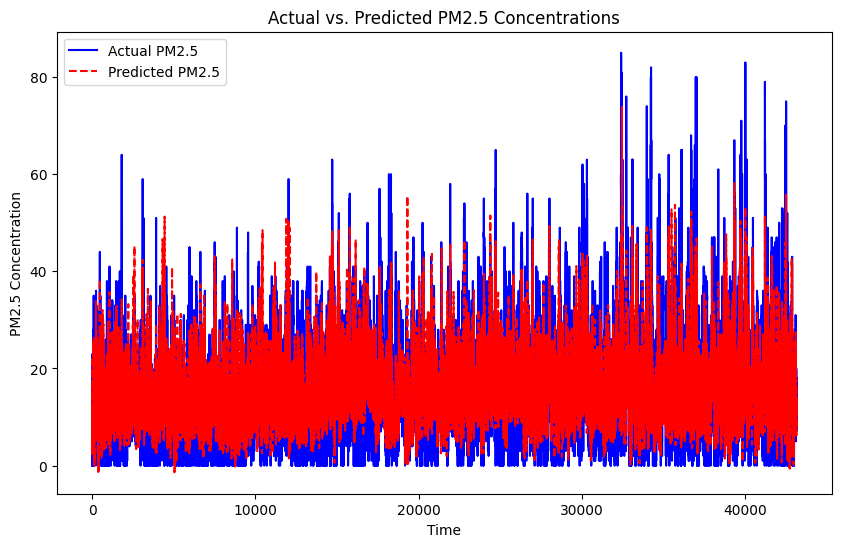

In [88]:
import matplotlib.pyplot as plt

# Sample code for plotting
plt.figure(figsize=(10, 6))
plt.plot(y_test_array, label='Actual PM2.5', color='blue')  # Actual values
plt.plot(y_pred_flatten, label='Predicted PM2.5', color='red', linestyle='--')  # Predicted values
plt.title('Actual vs. Predicted PM2.5 Concentrations')
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [125]:
print(data.columns)


Index(['time', 'station', 'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx',
       'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND', 'RH', 'SO2',
       'THC', 'UVB', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR'],
      dtype='object')


In [157]:
# Assuming 'PM2.5' is the name of the target variable column
endog_column = train_data['PM2.5']

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()




In [161]:
# Filter data for Banqiao station and specific variable 'PM2.5'
banqiao_data = data[data['station'] == 'Banqiao'][['time', 'PM2.5']]
banqiao_data['time'] = pd.to_datetime(banqiao_data['time'])
banqiao_data.set_index('time', inplace=True)

In [162]:
# Convert 'PM2.5' to numeric, coercing errors
banqiao_data['PM2.5'] = pd.to_numeric(banqiao_data['PM2.5'], errors='coerce')

# Handling missing values by forward filling
banqiao_data['PM2.5'].fillna(method='ffill', inplace=True)

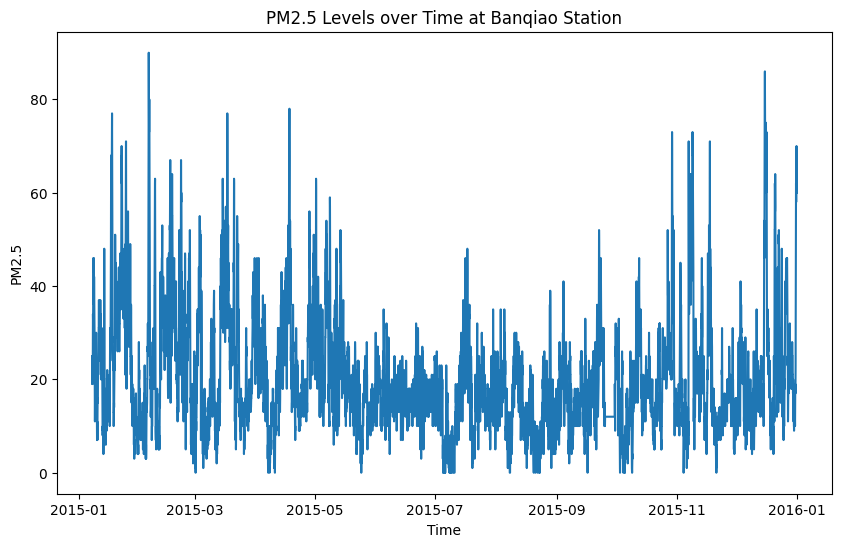

In [163]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(banqiao_data['PM2.5'])
plt.title('PM2.5 Levels over Time at Banqiao Station')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.show()


In [168]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the data
data = data[data['station'] == 'Banqiao']
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data['PM2.5'] = pd.to_numeric(data['PM2.5'], errors='coerce')
data['PM2.5'].fillna(method='ffill', inplace=True)

# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data['PM2.5'].iloc[:train_size], data['PM2.5'].iloc[train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)

# Calculate and print error metrics
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 10.055304715603269
Mean Squared Error (MSE): 206.71675467252032
Root Mean Squared Error (RMSE): 14.377647744764104


In [164]:
# Perform stationarity test
result = adfuller(banqiao_data['PM2.5'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(key, value)


ADF Statistic: -9.232459246972818
p-value: 1.6641706035043044e-15
Critical Values:
1% -3.431113719897179
5% -2.8618775125374465
10% -2.5669496530020592


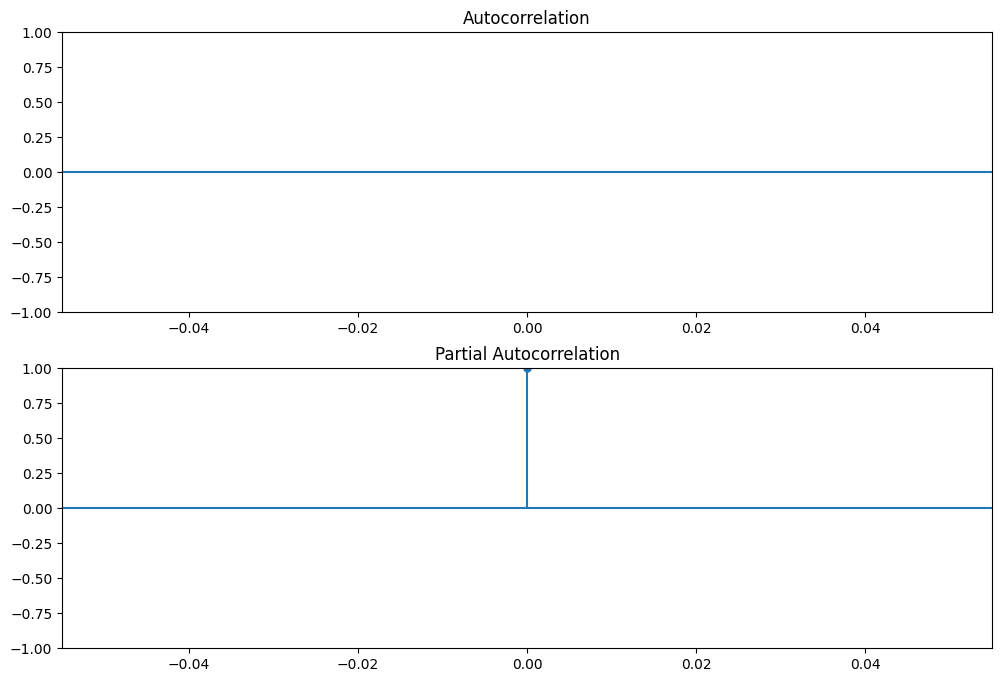

In [165]:
# Plotting ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(banqiao_data['PM2.5'], lags=50, ax=ax1)
plot_pacf(banqiao_data['PM2.5'], lags=50, ax=ax2)
plt.show()


In [166]:
# Fitting the ARIMA(1, 0, 1) model
model = ARIMA(banqiao_data['PM2.5'], order=(1, 0, 1))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [167]:
# Display the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 8760
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -21820.963
Date:                Fri, 12 Apr 2024   AIC                          43649.926
Time:                        08:20:44   BIC                          43678.238
Sample:                    01-01-2015   HQIC                         43659.573
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1764      0.740     27.282      0.000      18.727      21.626
ar.L1          0.9220      0.003    269.492      0.000       0.915       0.929
ma.L1          0.6136      0.005    120.392      0.0